# Trying to model ignition delay from RMG for Iso-octane


In [1]:
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from cantera import ck2cti
ck2cti.main([
    '--input=/Users/ebubeajulu/Code/GTL/ic8/chemkin/chem_annotated.inp',
    '--output=/Users/ebubeajulu/Code/GTL/ic8/chemkin/chem_annotated.cti',
    '--permissive'
        ])

Wrote CTI mechanism file to '/Users/ebubeajulu/Code/GTL/ic8/chemkin/chem_annotated.cti'.
Mechanism contains 236 species and 3192 reactions.
Validating mechanism...

**** WARNING ****
For species HOCHO(60), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678
PASSED.


In [3]:
gas = ct.Solution('/Users/ebubeajulu/Code/GTL/ic8/chemkin/chem_annotated.cti')



**** WARNING ****
For species HOCHO(60), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [4]:
sorted(gas.species_names)

['Ar',
 'C(36)',
 'C2(54)',
 'C2H(4)',
 'C2H2(27)',
 'C2H3(24)',
 'C2H3O2(48)',
 'C2H3O2(69)',
 'C2H3O3(61)',
 'C2H4(11)',
 'C2H4(700)',
 'C2H4O(44)',
 'C2H4O2(65)',
 'C2H4O3(68)',
 'C2H5(35)',
 'C2H5O(41)',
 'C2H5O(45)',
 'C2H5O(57)',
 'C2H5O2(42)',
 'C2H5O2(47)',
 'C2H5O2(64)',
 'C2H5O3(58)',
 'C2H6(39)',
 'C2H6O(56)',
 'C2H6O2(63)',
 'C2O(55)',
 'C3H6(12)',
 'C3H6O(79)',
 'C4H6O(305)',
 'C4H8O(291)',
 'C4H8O(292)',
 'C5H10(401)',
 'C5H11(670)',
 'C7H13(836)',
 'C7H13(882)',
 'C7H14(721)',
 'C7H14(722)',
 'C7H14(736)',
 'C7H15(683)',
 'C7H15(684)',
 'C8H16(749)',
 'C8H17(685)',
 'C8H17(686)',
 'C8H17(687)',
 'C8H17(688)',
 'CH(3)',
 'CH2(25)',
 'CH2(S)(30)',
 'CH2CHO(23)',
 'CH2CO(26)',
 'CH2O(9)',
 'CH2OH(31)',
 'CH2OOH(38)',
 'CH3(20)',
 'CH3CHO(40)',
 'CH3CO(22)',
 'CH3O(32)',
 'CH3OH(29)',
 'CH3OO(34)',
 'CH3OOH(37)',
 'CH4(10)',
 'CHCHO(49)',
 'CHCHOH(53)',
 'CO(6)',
 'CO2(7)',
 'H(15)',
 'H2(13)',
 'H2CC(43)',
 'H2O(8)',
 'H2O2(19)',
 'HCCO(51)',
 'HCCOH(52)',
 'HCO(21)',
 'HCO

In [5]:
gas.TP = 900, 10e6
gas.set_equivalence_ratio(phi=1.0, fuel='iC8H18(1)', oxidizer='O2(2):0.2, N2:0.8' )
gas()


  gas:

       temperature             900  K
          pressure           1e+07  Pa
           density         40.2989  kg/m^3
  mean mol. weight         30.1557  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       5.867e+05        1.769e+07     J
   internal energy      3.3856e+05        1.021e+07     J
           entropy          6719.6        2.026e+05     J/K
    Gibbs function     -5.4609e+06       -1.647e+08     J
 heat capacity c_p          1280.5        3.861e+04     J/K
 heat capacity c_v          1004.8         3.03e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.787402         0.731465         -20.2342
         iC8H18(1)       0.015748         0.059654         -94.4155
             O2(2)        0.19685         0.208881         -23.3054
     [ +233 minor]          

In [6]:
def set_gas_concentrations(gas, phi):
    """
    Set the concentrations in the gas according to the description
    in the paper by 
    """
    # Set it to desired stoichiometry with synthetic air (20% O2 : 80% N2)
    gas.set_equivalence_ratio(phi=1.0, fuel='iC8H18(1)', oxidizer='O2(2):0.2, N2:0.8' )
    # Then dilute the whole thing 1:2 with extra N2
    gas.X = gas.X / 3.0 
    gas.X[gas.species_index('N2')] += 2./3.

set_gas_concentrations(gas, 1.0)
gas()


  gas:

       temperature             900  K
          pressure           1e+07  Pa
           density         40.2989  kg/m^3
  mean mol. weight         30.1557  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       5.867e+05        1.769e+07     J
   internal energy      3.3856e+05        1.021e+07     J
           entropy          6719.6        2.026e+05     J/K
    Gibbs function     -5.4609e+06       -1.647e+08     J
 heat capacity c_p          1280.5        3.861e+04     J/K
 heat capacity c_v          1004.8         3.03e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.787402         0.731465         -20.2342
         iC8H18(1)       0.015748         0.059654         -94.4155
             O2(2)        0.19685         0.208881         -23.3054
     [ +233 minor]          

In [7]:
def get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=False):
    """
    A general function to find the igniton delay.
    Using C2H + O --> CH* as the indication of ignition
    
    gas is a cantera Solution object
    temperature in K
    pressure_bar is in bar
    mole_fractions is a dict
    """
    gas.TPX = temperature, pressure_bar*1e5, mole_fractions

    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])
    
    time = 0.0
    end_time = 10e-3
    
    times = []
    concentrations = []
    pressures = []
    temperatures = []
    
    print_data = True
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        # take a timestep
        # the size of the step will be determined by the ODE solver
        # depending on how quickly things are changing.
        reactor_network.step()
    
    print("Reached end time {0:.2f} ms in {1} steps".format(times[-1]*1e3, len(times)))
    # convert the lists into arrays
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)

    if plot:
        plt.subplot(2,1,1)
        plt.plot(times*1e3, pressures/1e5)
        plt.ylabel("Pressure (bar)", color='b')
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Temperature (K)', color='r')
        ax2.plot(times*1e3, temperatures, 'r')
    # Using C2H + O --> CH* as the indication of ignition
    i_c2h = gas.species_index('C2H(4)')   
    i_o = gas.species_index('O(5)')
    excited_ch_generation = concentrations[:,i_o] * concentrations[:,i_c2h]
    if plot:
        plt.subplot(2,1,2)
        plt.plot(times*1e3, excited_ch_generation, 'g')
        plt.ylabel("CH* emission")
        plt.ylim(0,max(1e-13,1.1*max(excited_ch_generation)))
        plt.xlabel("Time (ms)")
        plt.tight_layout()
        plt.show()
    step_with_highest_ch_gen = excited_ch_generation.argmax()
    if step_with_highest_ch_gen > 1 and excited_ch_generation.max()>1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_ch_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature, pressure_bar, ignition_time_ms))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition detected".format(temperature, pressure_bar))
        return np.infty

In [8]:
def get_ignition_delay_air(temperature, pressure_bar=10, phi=1.0, plot=False):
    """
    For figure 14
    
    temperature in K
    pressure in bar
    phi is equivalence ratio
    burns DME in air
    """
    set_gas_concentrations(gas,phi)
    mole_fractions = gas.X

    time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot)
    return time

Reached end time 10.01 ms in 1751 steps


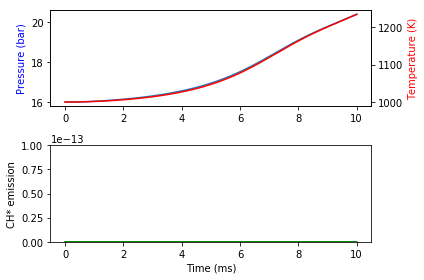

At 1000 K 16 bar, no ignition detected


In [9]:
get_ignition_delay_air(1000, 16, 1, plot=True)
plt.rcParams['figure.figsize'] = [10, 8]


# Figure 14 ignition delay times from LLNL for iso-octane in N2 as bath gas comparing to the Dagaut et al 2014 

In [10]:
RMG_temperatures = 1000/np.linspace(0.75,1.55,25)
pressures_bar = 16
phi = 1

RMG_results = dict()
times = []
for T in RMG_temperatures:
    t = get_ignition_delay_air(T,pressures_bar, phi, plot=False)
    times.append(t)
    RMG_results[pressures_bar]=times

Reached end time 10.16 ms in 5591 steps
At 1333.33333333 K 16 bar, ignition delay time is 0.752962791978 ms
Reached end time 10.02 ms in 5906 steps
At 1276.59574468 K 16 bar, ignition delay time is 1.34223588654 ms
Reached end time 10.04 ms in 5984 steps
At 1224.48979592 K 16 bar, ignition delay time is 2.24779224887 ms
Reached end time 10.05 ms in 6181 steps
At 1176.47058824 K 16 bar, ignition delay time is 3.52015059891 ms
Reached end time 10.06 ms in 6531 steps
At 1132.0754717 K 16 bar, ignition delay time is 5.13208424649 ms
Reached end time 10.00 ms in 6168 steps
At 1090.90909091 K 16 bar, ignition delay time is 7.0092918194 ms
Reached end time 10.01 ms in 6199 steps
At 1052.63157895 K 16 bar, ignition delay time is 9.12168419872 ms
Reached end time 10.00 ms in 1652 steps
At 1016.94915254 K 16 bar, no ignition detected
Reached end time 10.00 ms in 1566 steps
At 983.606557377 K 16 bar, no ignition detected
Reached end time 10.01 ms in 905 steps
At 952.380952381 K 16 bar, no ignitio

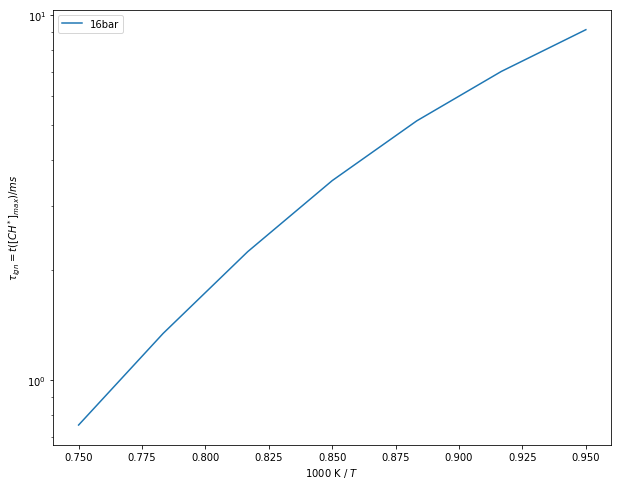

In [11]:
plt.semilogy(1000/RMG_temperatures,times,label='{}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.rcParams['figure.figsize'] = [10, 8]


In [12]:
import pickle
with open('ic8-LLNL.pkl') as fp:
    (LLNL_temperatures, LLNL_results) = pickle.load(fp)

<function matplotlib.pyplot.show>

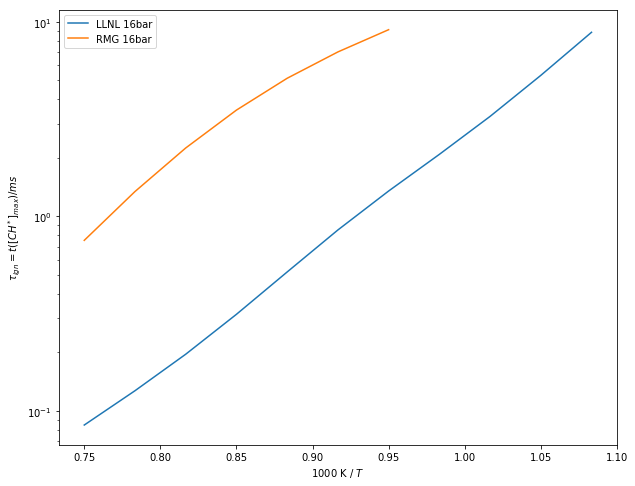

In [13]:
plt.semilogy(1000/LLNL_temperatures,LLNL_results[pressures_bar],label='LLNL {}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')


plt.semilogy(1000/RMG_temperatures,times,label='RMG {}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.rcParams['figure.figsize'] = [10, 8]

plt.show